In [1]:
import sys
sys.path.append("../firedanger/")
from firedanger import firedanger
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
# test with time series data

#fire = firedanger('/home/steidani/windows/data/forest_fire/test.csv')

#fire = firedanger('/home/steidani/windows/data/meteoswiss/COSMO-1/analysis/cosmo-1_ana_2018080100.nc')
fire = firedanger()
ds = xr.open_mfdataset('/home/steidani/windows/data/meteoswiss/COSMO-1/analysis/cosmo-1_ana*.nc', parallel=True)
fire.read_xarray(ds)

In [3]:
fire.ds = fire.ds.sel(time=datetime.time(12))
fire.ds['TOT_PREC'] = ds['TOT_PREC'].resample(time='1D', keep_attrs=True).mean('time')

In [22]:
# test with gridded data

ds = xr.open_mfdataset('/home/steidani/windows/data/meteoswiss/COSMO-1/analysis/cosmo-1_ana*.nc', parallel=True)
# time at 12 noon
ds_noon = ds.sel(time=datetime.time(12))

# for precip: daily mean
ds_noon['TOT_PREC'] = ds['TOT_PREC'].resample(time='1D').mean('time')

# create dataset without dask
ds_test = xr.Dataset({
    'TOT_PREC': xr.DataArray(
                data   = ds_noon['TOT_PREC'].values,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : 'mm/d'
                    }
                ),
    'T_2M': xr.DataArray(
                data   = ds_noon['T_2M'].values,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : 'degC'
                    }
                ),
    'U_10M': xr.DataArray(
                data   = ds_noon['U_10M'].values,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : 'm/s'
                    }
                ),
    'V_10M': xr.DataArray(
                data   = ds_noon['V_10M'].values,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : 'm/s'
                    }
                ),
    'RELHUM_2M': xr.DataArray(
                data   = ds_noon['RELHUM_2M'].values,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : '%'
                    }
                ),
    'WIND': xr.DataArray(
                data   = xu.sqrt(ds_noon.U_10M**2 + ds_noon.V_10M**2).values,   # enter data here
                dims   = ['time', 'lat', 'lon'],
                coords = {'time': ds_noon.time.values, 'lat': ds_noon.lat_1.values[:,1],'lon': ds_noon.lon_1.values[1,:]},
                attrs  = {
                    '_FillValue': -999.9,
                    'units'     : 'm/s'
                    }
                ),
            },
        attrs = {'example_attr': 'this is a global attribute'}
    )


fire = firedanger()
fire.read_xarray(ds_test)

In [4]:
fire

Xarray dataset with 13 time steps. 
            Available fields: grid_mapping_1, U_10M, V_10M, VMAX_10M, T_2M, RELHUM_2M, PS, Z0, TOT_PREC

In [5]:
#fire.dimensions
#fire.variables
fire.grid
#fire.ntime
#fire._get_name_latitude()

        y: 294 
        x: 429


In [6]:
fire.set_up(force=True)

INFO: 
 time: 'time'
 x axis: 'x_1'
 y axis: 'y_1'



In [7]:
fire.calc_windspeed(u="U_10M", v="V_10M")

INFO: Calculating wind speed... DONE


In [8]:
#fire.calc_ffmc(temp="T", precip="P", hum="H", wind="U")
#fire.calc_ffmc(temp="T_2M", precip="TOT_PREC", hum="RELHUM_2M", wind="WIND")
fire.calc_ffmc(temp="T_2M", precip="TOT_PREC", hum="RELHUM_2M", wind="wind")

INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'x_1'
 latitude: 'y_1'

../firedanger/firedanger.py:501: RuntimeWarning: overflow encountered in ffmc
  ffmc = indices.ffmc(self.ds[temp].isel(**{self._time_name: i_time}).values,
../firedanger/firedanger.py:501: RuntimeWarning: overflow encountered in ffmc
  ffmc = indices.ffmc(self.ds[temp].isel(**{self._time_name: i_time}).values,
INFO: Calculating ffmc... DONE


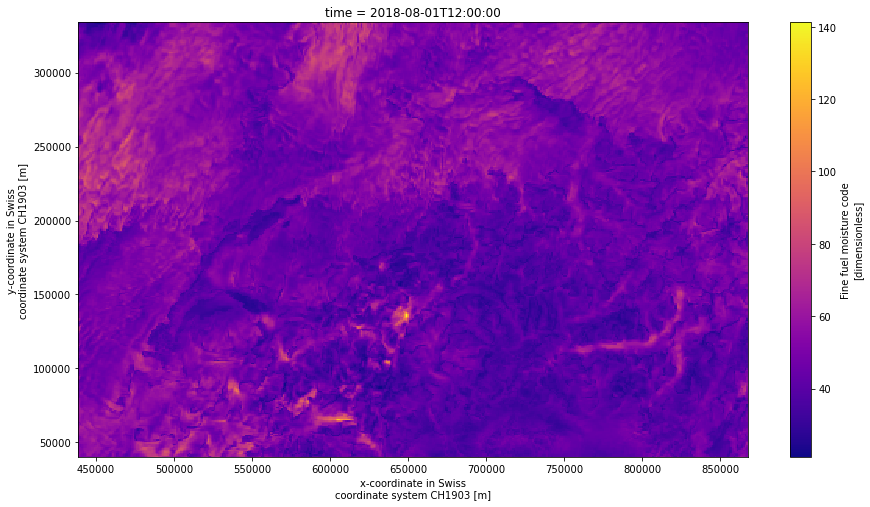

In [9]:
plt.figure(figsize=(15, 8))
fire.ffmc[0].plot(cmap="plasma")

In [10]:
from typing import Optional, Sequence, Union
from numba import jit, vectorize

In [34]:
day_lengths = np.array(
  [
      [11.5, 10.5, 9.2, 7.9, 6.8, 6.2, 6.5, 7.4, 8.7, 10, 11.2, 11.8],
      [10.1, 9.6, 9.1, 8.5, 8.1, 7.8, 7.9, 8.3, 8.9, 9.4, 9.9, 10.2],
      12 * [9],
      [7.9, 8.4, 8.9, 9.5, 9.9, 10.2, 10.1, 9.7, 9.1, 8.6, 8.1, 7.8],
      [6.5, 7.5, 9, 12.8, 13.9, 13.9, 12.4, 10.9, 9.4, 8, 7, 6],
  ]
)

drying_factors = np.array(
  [
      [6.4, 5.0, 2.4, 0.4, -1.6, -1.6, -1.6, -1.6, -1.6, 0.9, 3.8, 5.8],
      12 * [1.39],
      [-1.6, -1.6, -1.6, 0.9, 3.8, 5.8, 6.4, 5.0, 2.4, 0.4, -1.6, -1.6],
  ]
)

@vectorize
def _day_length(lat: Union[int, float], mth: int):  # Union[int, float]
  """Return the average day length for a month within latitudinal bounds."""
  if -30 > lat >= -90:
      dl = day_lengths[0, :]
  elif -15 > lat >= -30:
      dl = day_lengths[1, :]
  elif 15 > lat >= -15:
      return 9
  elif 30 > lat >= 15:
      dl = day_lengths[3, :]
  elif 90 >= lat >= 30:
      dl = day_lengths[4, :]
  elif lat > 90 or lat < -90:
      raise ValueError("Invalid lat specified.")
  else:
      raise ValueError
  return dl[mth - 1]


In [36]:
a = _day_length(fire.ds[fire._latitude_name].values, 8)
len(a)

294

In [20]:
fire.ds['T_2M'].isel(**{fire._time_name: 1}).values * fire.ds[fire._latitude_name].values

ValueError: operands could not be broadcast together with shapes (294,429) (294,) 

In [41]:
# add dim
dummy_dim = xr.core.utils.get_temp_dimname(fire.T_2M.dims, "dummy")
lat_test = fire.ds['lat'].expand_dims({dummy_dim: [1]})

In [43]:
fire.T_2M.ndim

3

In [36]:
from typing import Optional, Sequence, Union
from numba import jit, vectorize

@vectorize
def dmc(t, p, h, mth: int, lat: float, dmc0: float): 
  """Compute the Duff moisture code over one time step (canadian index).

  Parameters
  ----------
  t: array
    Noon temperature [C].
  p : array
    rainfall amount in open over previous 24 hours, at noon [mm].
  h : array
    Noon relative humidity [%].
  mth : integer array
    Month of the year [1-12].
  lat : float
    Latitude in degrees.
  dmc0 : float
    Previous value of the Duff moisture code.

  Returns
  -------
  array
    Duff moisture code at the current timestep

  Example
  ------- 
  dmc(17,0,42,6,45.98,6) == 8.5450511359999997
  """
  # clip humidity to [0,100]
  #h = np.clip(h, 0, 100)
  
  #if dmc0 is None:
  #    dmc0 = 6

  if t < -1.1:
      rk = 0
  else:
      dl = _day_length(lat, mth)
      # Eqs.16 and 17
      rk = 1.894 * (t + 1.1) * (100.0 - h) * dl * 0.0001  

  if p > 1.5:
      ra = p
      # Eq.11 Effective rainfall
      rw = 0.92 * ra - 1.27  
      # Eq.12 from R-package cffdrs
      wmi = 20.0 + 280.0 / np.exp(0.023 * dmc0) 
      if dmc0 <= 33.0:
          # Eq.13a
          b = 100.0 / (0.5 + 0.3 * dmc0)  
      else: # dmc0 > 33.0
          if dmc0 <= 65.0:
              # Eq.13b
              b = 14.0 - 1.3 * np.log(dmc0)  
          else:
                # Eq.13c
              b = 6.2 * np.log(dmc0) - 17.2 
      # Eq.14 duff moisture content after p
      wmr = wmi + (1000 * rw) / (48.77 + b * rw)  
      # Eq.15
      pr = 43.43 * (5.6348 - np.log(wmr - 20.0))  
  else:  # p <= 1.5
      pr = dmc0
  
  if pr < 0.0:
      pr = 0.0
  # Calculate final dmc
  dmc = pr + rk
  # Constraints: dmc is scaled between max(0, dmc)
  if dmc < 0:
      dmc = 0.0
      
  return dmc

day_lengths = np.array(
  [
      [11.5, 10.5, 9.2, 7.9, 6.8, 6.2, 6.5, 7.4, 8.7, 10, 11.2, 11.8],
      [10.1, 9.6, 9.1, 8.5, 8.1, 7.8, 7.9, 8.3, 8.9, 9.4, 9.9, 10.2],
      12 * [9],
      [7.9, 8.4, 8.9, 9.5, 9.9, 10.2, 10.1, 9.7, 9.1, 8.6, 8.1, 7.8],
      [6.5, 7.5, 9, 12.8, 13.9, 13.9, 12.4, 10.9, 9.4, 8, 7, 6],
  ]
)

@jit
def _day_length(lat, mth: int):  
  """Return the average day length for a month within latitudinal bounds."""
  if -30 > lat >= -90:
      dl = day_lengths[0, :]
  elif -15 > lat >= -30:
      dl = day_lengths[1, :]
  elif 15 > lat >= -15:
      return 9
  elif 30 > lat >= 15:
      dl = day_lengths[3, :]
  elif 90 >= lat >= 30:
      dl = day_lengths[4, :]
  elif lat > 90 or lat < -90:
      raise ValueError("Invalid lat specified.")
  else:
      raise ValueError
  return dl[mth - 1]


#a = dmc(fire.T.data, fire.P.data, fire.H.data, 8, 47.0, 6)    
a = dmc(fire.T_2M.data, fire.TOT_PREC.data, fire.RELHUM_2M.data, 8, 47.0, 6)    